**BacktestEngine notebook**

The purpose of this notebook is to illustrate how to use the `BacktestEngine` class to do the back-testing. To have the greatest flexibility, this engine is designed to work for any model objects which have a `fit` method and a `predict` method, by writing some call back functions. The default settings work for **Orbit** model object automatically. Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* expanding window: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* rolling window: for each back-testing model training, the training window length is fixed but the window is moving forward.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import sys

sys.path.append("../../orbit")
from orbit.lgt import LGT
from orbit.dlt import DLT
from orbit.backtest import BacktestEngine
from orbit.utils.metrics import mape, smape, wmape
from orbit.backtest import run_group_backtest, get_scores

## Load data

In [2]:
data_path = "../examples/data/iclaims.example.csv"
raw_data = pd.read_csv(data_path, parse_dates=['week'])

## log transformation
data = raw_data.copy()
data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)

print(data.shape)
data.head(5)

(443, 5)


,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


## Orbit model object

###  expanding window

In [3]:
date_col = 'week'
response_col = 'claims'
regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job']

min_train_len = 300
forecast_len = 20
incremental_len = 20

mod = LGT(date_col = date_col,
    response_col = response_col,
    regressor_col = regressor_col,
    seasonality = 52,
    seed = 8888,
    predict_method = 'map'
)

#### initialization and create meta data

In [4]:
bt_expand = BacktestEngine(mod, data)

In [5]:
bt_expand.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='expanding')

In [6]:
print(bt_expand.bt_meta.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])


In [7]:
bt_expand.bt_meta[0]

{'model': <orbit.lgt.LGT at 0x1297b9518>,
 'train_start_date': Timestamp('2010-01-03 00:00:00'),
 'train_end_date': Timestamp('2015-09-27 00:00:00'),
 'train_idx': range(0, 300),
 'test_idx': range(300, 320),
 'forecast_dates': 300   2015-10-04
 301   2015-10-11
 302   2015-10-18
 303   2015-10-25
 304   2015-11-01
 305   2015-11-08
 306   2015-11-15
 307   2015-11-22
 308   2015-11-29
 309   2015-12-06
 310   2015-12-13
 311   2015-12-20
 312   2015-12-27
 313   2016-01-03
 314   2016-01-10
 315   2016-01-17
 316   2016-01-24
 317   2016-01-31
 318   2016-02-07
 319   2016-02-14
 Name: week, dtype: datetime64[ns]}

#### run back-testing

In [8]:
bt_expand.run(verbose=True, save_results=False, pred_col='prediction')

  0%|          | 0/7 [00:00<?, ?it/s]

run expanding window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016


 29%|██▊       | 2/7 [00:00<00:00,  5.12it/s]

training and forcasting for horizon 02/21/2016 -- 07/03/2016
training and forcasting for horizon 07/10/2016 -- 11/20/2016


 57%|█████▋    | 4/7 [00:00<00:00,  5.55it/s]

training and forcasting for horizon 11/27/2016 -- 04/09/2017
training and forcasting for horizon 04/16/2017 -- 08/27/2017


 86%|████████▌ | 6/7 [00:01<00:00,  5.19it/s]

training and forcasting for horizon 09/03/2017 -- 01/14/2018
training and forcasting for horizon 01/21/2018 -- 06/03/2018


100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


In [9]:
bt_expand.bt_res.head()

,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.416718,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.489585,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.414058,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.457153,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.455492,5


### rolling window

In [10]:
bt_roll = BacktestEngine(mod, data)
bt_roll.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='rolling')
bt_roll.run(verbose=True, save_results=False, pred_col='prediction')
bt_roll.bt_res.head()

 14%|█▍        | 1/7 [00:00<00:01,  5.42it/s]

run rolling window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016
training and forcasting for horizon 02/21/2016 -- 07/03/2016


 43%|████▎     | 3/7 [00:00<00:00,  5.42it/s]

training and forcasting for horizon 07/10/2016 -- 11/20/2016
training and forcasting for horizon 11/27/2016 -- 04/09/2017


 71%|███████▏  | 5/7 [00:00<00:00,  5.28it/s]

training and forcasting for horizon 04/16/2017 -- 08/27/2017
training and forcasting for horizon 09/03/2017 -- 01/14/2018


100%|██████████| 7/7 [00:01<00:00,  5.92it/s]

training and forcasting for horizon 01/21/2018 -- 06/03/2018


,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.416718,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.489585,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.414058,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.457153,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.455492,5


### using number of trainings

User can also define number of trainings using `n_train` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [11]:
bt_roll2 = BacktestEngine(mod, data)
bt_roll2.create_meta(min_train_len, incremental_len, forecast_len, n_train=2, scheme='rolling')
bt_roll2.run(verbose=True, save_results=False, pred_col='prediction')
bt_roll2.bt_res.head()

  0%|          | 0/2 [00:00<?, ?it/s]

run rolling window back-testing:
training and forcasting for horizon 09/17/2017 -- 01/28/2018


 50%|█████     | 1/2 [00:00<00:00,  5.09it/s]

training and forcasting for horizon 02/04/2018 -- 06/17/2018


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2017-09-10,2017-09-17,12.265817,12.206866,1
1,2010-01-03,2017-09-10,2017-09-24,12.268986,12.161800,2
2,2010-01-03,2017-09-10,2017-10-01,12.226757,12.200448,3
3,2010-01-03,2017-09-10,2017-10-08,12.342529,12.351990,4
4,2010-01-03,2017-09-10,2017-10-15,12.233649,12.317548,5


## Sklearn model object - Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

def fit_callbacks_sklearn(model, train_df, response_col, regressor_col, **kwargs):
    y = train_df[response_col]
    X = train_df[regressor_col]
    model.fit(X, y)
    return 

def pred_callbacks_sklearn(model, test_df, response_col, regressor_col, **kwargs):
    return model.predict(test_df[regressor_col])

In [13]:
mod = RandomForestRegressor(n_estimators = 50)

In [14]:
bt_expand = BacktestEngine(mod, data, date_col=date_col, response_col=response_col)

bt_expand.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='expanding')

bt_expand.run(verbose=True, save_results=False, pred_col=None,
              fit_callbacks=fit_callbacks_sklearn, pred_callbacks=pred_callbacks_sklearn,
              response_col=response_col, regressor_col=regressor_col)

 43%|████▎     | 3/7 [00:00<00:00, 20.84it/s]

run expanding window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016
training and forcasting for horizon 02/21/2016 -- 07/03/2016
training and forcasting for horizon 07/10/2016 -- 11/20/2016
training and forcasting for horizon 11/27/2016 -- 04/09/2017
training and forcasting for horizon 04/16/2017 -- 08/27/2017


100%|██████████| 7/7 [00:00<00:00, 19.66it/s]

training and forcasting for horizon 09/03/2017 -- 01/14/2018
training and forcasting for horizon 01/21/2018 -- 06/03/2018


In [15]:
bt_expand.bt_res.head()

,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.269815,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.314558,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.298409,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.297171,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.288372,5


## Prophet model object

In [16]:
from fbprophet import Prophet
import inspect

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [17]:
def model_callbacks_prophet(model):
    def _get_params(instance):
        """get initilization parameters via a prophet model object"""
        class_hierarchy = inspect.getmro(Prophet)
        init_signatures = [inspect.signature(c.__init__) for c in class_hierarchy if type(c) is not object]

        all_params = []
        for sig in init_signatures:
            params = [p for p in sig.parameters.values()
                      if p.name != 'self' and p.kind != p.VAR_KEYWORD
                      and p.kind != p.VAR_POSITIONAL]
            all_params.extend(params)
        param_names = [p.name for p in all_params]
        out = dict()
        for key in param_names:
            out[key] = getattr(instance, key)

        return out

    def bind(instance, _get_params):
        def binding_scope_fn(): 
            return _get_params(instance)
        return binding_scope_fn
    model.get_params = bind(model, _get_params)
    
    return model


def fit_callbacks_prophet(model, train_df, date_col, response_col, regressor_col):
    train_df = train_df.rename(columns={date_col: "ds", response_col: "y"})
    if regressor_col is not None:
        for regressor in regressor_col:
            model.add_regressor(regressor) 
    model.fit(train_df)
    
    return 

def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
    test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
    return model.predict(test_df)

In [18]:
mod = Prophet()

In [19]:
bt_expand = BacktestEngine(mod, data, date_col=date_col, response_col=response_col, 
                           model_callbacks=model_callbacks_prophet)

bt_expand.create_meta(min_train_len, incremental_len, forecast_len, 
                           start_date=None, end_date=None, keep_cols=None,
                           scheme='expanding')

bt_expand.run(verbose=True, save_results=False, 
              fit_callbacks=fit_callbacks_prophet, pred_callbacks=pred_callbacks_prophet, pred_col='yhat', 
              date_col=date_col, response_col=response_col, regressor_col=regressor_col)

bt_expand.bt_res.head()

  0%|          | 0/7 [00:00<?, ?it/s]

run expanding window back-testing:
training and forcasting for horizon 10/04/2015 -- 02/14/2016


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 14%|█▍        | 1/7 [00:01<00:07,  1.27s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 02/21/2016 -- 07/03/2016


 29%|██▊       | 2/7 [00:02<00:06,  1.29s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 07/10/2016 -- 11/20/2016


 43%|████▎     | 3/7 [00:03<00:05,  1.31s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 11/27/2016 -- 04/09/2017


 57%|█████▋    | 4/7 [00:05<00:03,  1.32s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 04/16/2017 -- 08/27/2017


 71%|███████▏  | 5/7 [00:06<00:02,  1.35s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 09/03/2017 -- 01/14/2018


 86%|████████▌ | 6/7 [00:08<00:01,  1.38s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training and forcasting for horizon 01/21/2018 -- 06/03/2018


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon
0,2010-01-03,2015-09-27,2015-10-04,12.333480,12.353443,1
1,2010-01-03,2015-09-27,2015-10-11,12.454970,12.408038,2
2,2010-01-03,2015-09-27,2015-10-18,12.358193,12.444854,3
3,2010-01-03,2015-09-27,2015-10-25,12.410502,12.447369,4
4,2010-01-03,2015-09-27,2015-11-01,12.462419,12.449554,5


## Backtest Multiple Models

In [20]:
model_names = ["LGT-MAP",  "DLT-MAP", "Prophet", 'RF']
pred_cols = ['prediction', 'prediction', 'yhat', None]
model_callbacks = [None]*2 + [model_callbacks_prophet] + [None]
fit_callbacks = [None]*2 + [fit_callbacks_prophet] + [fit_callbacks_sklearn]
pred_callbacks = [None]*2 + [pred_callbacks_prophet] + [pred_callbacks_sklearn]
transform_fun = np.exp
data['city_name'] = 'DUMMY'

In [21]:
date_col = 'week'
resp_col = 'claims'
# min_train_len = 350
# forecast_len = 52
# incremental_len = 10

key_col = 'city_name'
keep_cols = ['city_name']
city_name_list = data['city_name'].unique()
scheme = 'expanding'
transform_fun = np.exp
mod_list = [ 
    
    ## vanilla LGT
    LGT(response_col = resp_col,
        date_col = date_col,
        seasonality = 52,
        seed = 1,
        predict_method = 'map'
),
    
    DLT(response_col=resp_col,
        date_col=date_col,
        seasonality=52,
        num_warmup=1000, 
        num_sample=2000,
        predict_method = 'map',
        damped_factor_fixed=-1,
        seed = 1
),
    Prophet(),
    RandomForestRegressor(n_estimators = 50)
]

In [23]:
np.random.seed(2019) # to have full reproducibility for mcmc samples
bt_res =  run_group_backtest(data, date_col, resp_col, key_col, pred_cols,
                             mod_list, model_callbacks, fit_callbacks, pred_callbacks,
                             min_train_len, incremental_len, forecast_len, n_train=None,
                             transform_fun=transform_fun, start_date=None, end_date=None,
                             keep_cols = keep_cols, 
                             regressor_col=regressor_col,
                             mod_names = model_names,
                             scheme = scheme)

  0%|          | 0/7 [00:00<?, ?it/s]

time elapsed 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time elapsed 00:00:03


 14%|█▍        | 1/7 [00:01<00:08,  1.35s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 29%|██▊       | 2/7 [00:02<00:06,  1.38s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 43%|████▎     | 3/7 [00:04<00:05,  1.38s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 57%|█████▋    | 4/7 [00:05<00:04,  1.38s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

time elapsed 00:00:09


100%|██████████| 7/7 [00:00<00:00, 18.10it/s]

time elapsed 00:00:00


In [24]:
bt_res.head(5)

,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon,city_name,model
0,2010-01-03,2015-09-27,2015-10-04,227176.0,251315.809310,1,DUMMY,LGT-MAP
1,2010-01-03,2015-09-27,2015-10-11,256522.0,266707.860400,2,DUMMY,LGT-MAP
2,2010-01-03,2015-09-27,2015-10-18,232860.0,247535.230183,3,DUMMY,LGT-MAP
3,2010-01-03,2015-09-27,2015-10-25,245365.0,258516.821608,4,DUMMY,LGT-MAP
4,2010-01-03,2015-09-27,2015-11-01,258440.0,260463.968189,5,DUMMY,LGT-MAP


### back-testing result analysis

Internal method is provided to give a quick analysis of the back-testing runs. It is flexible for uses to define their own metrics and aggregation strategy based on the back-testing run results.

In [25]:
bt_horizon_summary=get_scores(result=bt_res, by=['model','pred_horizon'])

In [26]:
bt_horizon_summary['smape'].head(5)

,model,pred_horizon,smape
0,DLT-MAP,1,0.060701
1,DLT-MAP,2,0.073704
2,DLT-MAP,3,0.061413
3,DLT-MAP,4,0.066437
4,DLT-MAP,5,0.050915


### plotting

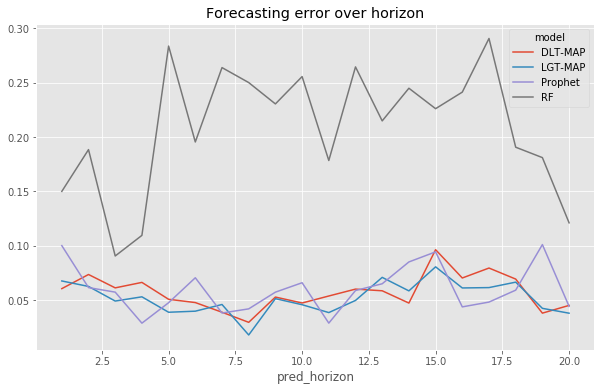

In [27]:
bt_horizon_summary['smape'].pivot(index='pred_horizon', columns='model', values='smape').\
plot(figsize=(10,6), title='Forecasting error over horizon')